# 4_Plume_Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from plume_learn.plume_utils.viz import show_images, label_violinplot
from plume_learn.plume_utils.manage_plume import remove_all_0_plume, load_json
from plume_learn.plume_analyzer.PlumeDataset import plume_dataset
from m3util.viz.layout import layout_fig
from m3util.viz.text import labelfigs, add_text_to_figure
from m3util.viz.lines import draw_lines
from sro_sto_plume.modify_df import modify_df

## 1. Load Plume data

### 1.1 load experiment conditions

In [7]:
growth_names = ['Sample X', 'Sample 5']
growth_ids = ['YG063', 'YG069']
plume_recording_root = '../data/Plumes/plume_recordings/plume_recordings/'
output_root = '../data/Plumes/plume_metrics/'

### 1.2 load metrics for every plume frame

In [8]:
df_frame_metrics = []
for id, growth_name in zip(growth_ids, growth_names):
    file = glob.glob(f'{output_root}/{id}*metrics.csv')[0]
    df = pd.read_csv(file)
    df_processed = modify_df(df, id, growth_name)
    df_frame_metrics.append(df_processed)
df_frame_metrics = pd.concat(df_frame_metrics, ignore_index=True)
df_frame_metrics

C:\Users\yig319\AppData\Local\Temp\ipykernel_51112\4126169575.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_51112\4126169575.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


,Plume Index,Time (µs),Distance (m),Velocity (m/s),Area (a.u.),Threshold,Growth Name,Growth_ID
0,0,0.0,0.000000,0.000000,0.0,200,Sample X,YG063
1,0,0.5,0.000000,0.000000,0.0,200,Sample X,YG063
2,0,1.0,0.006847,13694.524496,877.0,200,Sample X,YG063
3,0,1.5,0.014317,14939.481268,3278.0,200,Sample X,YG063
4,0,2.0,0.021164,13694.524496,8774.0,200,Sample X,YG063
...,...,...,...,...,...,...,...,...
84987,287,61.5,0.032680,0.000000,0.0,200,Sample 5,YG069
84988,287,62.0,0.032680,0.000000,0.0,200,Sample 5,YG069
84989,287,62.5,0.032680,0.000000,0.0,200,Sample 5,YG069
84990,287,63.0,0.032680,0.000000,0.0,200,Sample 5,YG069


### 1.3 calculate max area and incident velocity

In [9]:
# analyze the max area
idx = df_frame_metrics.groupby(['Growth Name', 'Plume Index'])['Area (a.u.)'].idxmax()
df_max_area = df_frame_metrics.loc[idx, ['Growth Name', 'Plume Index', 'Time (µs)', 'Area (a.u.)']].reset_index(drop=True)
df_max_area.rename(columns={'Area (a.u.)': 'Max Area (a.u.)'}, inplace=True)
df_max_area.rename(columns={'Time (µs)': 'Time at Max Area (µs)'}, inplace=True)

# analyze plume Velocity that can be tracked before landing on the substrate
## calculate the velocity between 2.8cm and 2.9cm for the incident velocity
df_filtered = df_frame_metrics[(df_frame_metrics['Distance (m)'] >= 0.028) & (df_frame_metrics['Distance (m)'] <= 0.029)] 
df_unique = df_filtered.drop_duplicates(subset=['Time (µs)', 'Distance (m)', 'Velocity (m/s)', 'Area (a.u.)', 'Threshold'])
incident_Velocity = df_unique.groupby(['Growth Name', 'Plume Index'])['Velocity (m/s)'].mean().reset_index()
incident_Velocity.rename(columns={'Velocity (m/s)': 'Incident Velocity (m/s)'}, inplace=True)

df_plume_metrics = pd.merge(df_max_area, incident_Velocity, on=['Growth Name', 'Plume Index'])
df_plume_metrics.sample(5)

,Growth Name,Plume Index,Time at Max Area (µs),Max Area (a.u.),Incident Velocity (m/s)
51,Sample 5,125,3.0,16271.0,5913.544669
179,Sample X,117,3.0,15712.0,4979.827089
301,Sample X,355,3.0,15559.0,5602.305476
102,Sample 5,244,3.0,16217.0,6536.023055
253,Sample X,264,3.0,15096.0,4668.587896


## 2. Introduction to Plume Dynamics Analysis

### 2.3 Violin Plot of Plume Max Area and Incident Velocity Statics

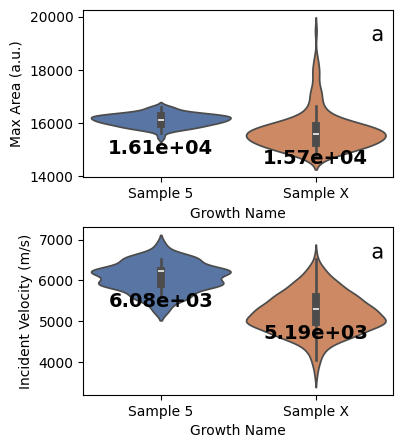

In [10]:
fig, axes = layout_fig(2, 1, figsize=(4, 5), subplot_style='gridspec', spacing=(0, 0.3), layout='tight')

sns.violinplot(x='Growth Name', y='Max Area (a.u.)', data=df_plume_metrics, width=0.9, ax=axes[0], palette='deep', hue='Growth Name', legend=False)
mean_max_area = df_plume_metrics.groupby('Growth Name')['Max Area (a.u.)'].mean()
label_violinplot(axes[0], mean_max_area, label_type='average_value', text_pos='center', value_format='scientific',
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.08})
labelfigs(axes=axes[0], number=0, size=15, style='bw', loc='tr', inset_fraction=(0.15, 0.05))

sns.violinplot(x='Growth Name', y='Incident Velocity (m/s)', data=df_plume_metrics, width=0.9, ax=axes[1], palette='deep', hue='Growth Name', legend=False)
mean_incident_velocity = df_plume_metrics.groupby('Growth Name')['Incident Velocity (m/s)'].mean()
label_violinplot(axes[1], mean_incident_velocity, label_type='average_value', text_pos='center', value_format='scientific',
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})
labelfigs(axes=axes[1], number=0, size=15, style='bw', loc='tr', inset_fraction=(0.15, 0.05))

# plt.savefig('../figures/4_Plume_metrics_violinplot.png', dpi=600)
# plt.savefig('../figures/4_Plume_metrics_violinplot.svg', dpi=600)
plt.show()

### 2.4 Heat Map Plot of Plume Max Area between clean sample and contaminated sample

In [1]:
target_growth_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5']
df_sample = df_frame_metrics[(df_frame_metrics['Time (µs)'] >= 0.5) & (df_frame_metrics['Time (µs)'] < 7)] 
# df_sample = df_sample[(df_sample['Growth Name'].isin(['Sample 1', 'Sample 3']))] 
df_sample = df_sample[df_sample['Growth Name'].isin(target_growth_names)]
df_sample = df_sample.dropna()  # Remove all rows with NaN values
df_sample

fig, axes = layout_fig(2, 1, figsize=(8, 6), subplot_style='gridspec', spacing=(0, 0.3), layout='tight')
# fig, axes = plt.subplots(2, 1, figsize=(8, 6))
for i, (ax, growth) in enumerate(zip(axes, target_growth_names)):
    df_pivot = df_sample[df_sample['Growth Name']==growth].pivot(index="Time (µs)", columns="Plume Index", values="Area (a.u.)")
    df_pivot = df_pivot.loc[:, (df_pivot != 0).any(axis=0)]  # remove the columns where all values are 0
    
    sns.heatmap(df_pivot, cmap='viridis', cbar_kws={'label': 'Area (a.u.)'}, ax=ax)
    ax.set_xlabel("Plume Index")
    ax.set_ylabel("Time (µs)")
    # ax.set_title(growth)
    labelfigs(axes=ax, number=i, size=15, style='wb', loc='tr', inset_fraction=(0.15, 0.05))

plt.savefig('../figures/5_Plume_Area_Heatmap.png', dpi=600)
plt.savefig('../figures/5_Plume_Area_Heatmap.svg', dpi=600)
# plt.suptitle("Plume Area heatmap with Time")
# plt.tight_layout()
plt.show()

NameError: name 'df_frame_metrics' is not defined

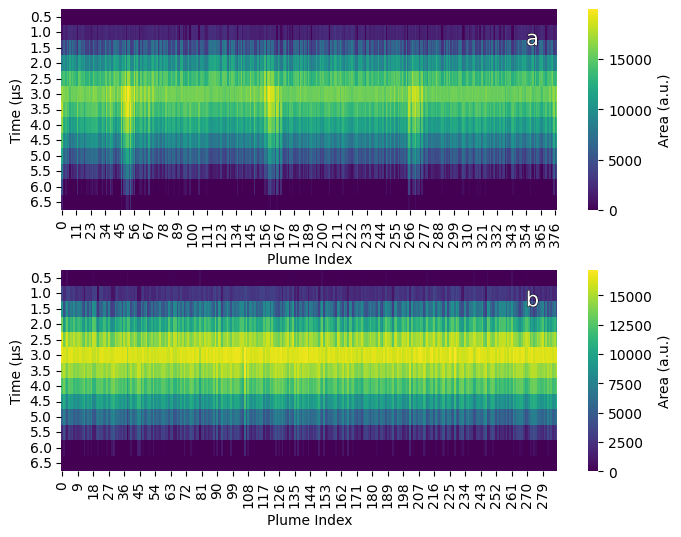

In [90]:
target_growth_names = ['Sample X', 'Sample 5']
df_sample = df_frame_metrics[(df_frame_metrics['Time (µs)'] >= 0.5) & (df_frame_metrics['Time (µs)'] < 7)] 
# df_sample = df_sample[(df_sample['Growth Name'].isin(['Sample 1', 'Sample 3']))] 
df_sample = df_sample[df_sample['Growth Name'].isin(target_growth_names)]
df_sample = df_sample.dropna()  # Remove all rows with NaN values
df_sample

fig, axes = layout_fig(2, 1, figsize=(8, 6), subplot_style='gridspec', spacing=(0, 0.3), layout='tight')
# fig, axes = plt.subplots(2, 1, figsize=(8, 6))
for i, (ax, growth) in enumerate(zip(axes, target_growth_names)):
    df_pivot = df_sample[df_sample['Growth Name']==growth].pivot(index="Time (µs)", columns="Plume Index", values="Area (a.u.)")
    df_pivot = df_pivot.loc[:, (df_pivot != 0).any(axis=0)]  # remove the columns where all values are 0
    
    sns.heatmap(df_pivot, cmap='viridis', cbar_kws={'label': 'Area (a.u.)'}, ax=ax)
    ax.set_xlabel("Plume Index")
    ax.set_ylabel("Time (µs)")
    # ax.set_title(growth)
    labelfigs(axes=ax, number=i, size=15, style='wb', loc='tr', inset_fraction=(0.15, 0.05))

plt.savefig('../figures/5_Plume_Area_Heatmap.png', dpi=600)
plt.savefig('../figures/5_Plume_Area_Heatmap.svg', dpi=600)
# plt.suptitle("Plume Area heatmap with Time")
# plt.tight_layout()
plt.show()